Name : W. K. D. D. Senuruk  
## Edges & Corners

#### Derivatives of gaussian filter

These are the two partial derivatives of a 2D Gaussian filter

**Derivative with respect to x:** 

$$ \frac{\partial G}{\partial x} = -\frac{x}{2\pi \sigma^4} e^{-\frac{x^2 + y^2}{2\sigma^2}} = -\frac{x}{\sigma^2} G(x, y) $$

**Derivative with respect to y:**

$$ \frac{\partial G}{\partial y} = -\frac{y}{2\pi \sigma^4} e^{-\frac{x^2 + y^2}{2\sigma^2}} = -\frac{y}{\sigma^2} G(x, y) $$

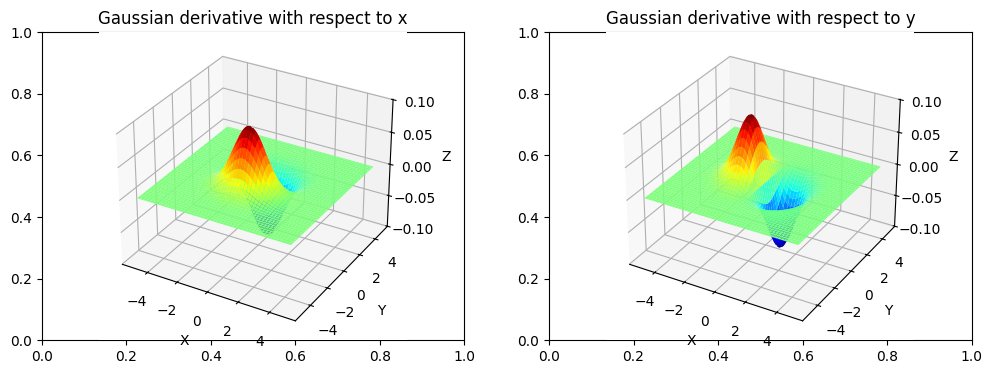

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

sigma = 1
spatial_resolution = 0.1
x = np.arange(-5, 5, spatial_resolution)
y = np.arange(-5, 5, spatial_resolution)
X, Y = np.meshgrid(x, y)
Z = (1/(2*np.pi*sigma**2)*np.exp(-(X**2+Y**2)/(2*sigma**2)))

# creating derivative matrices with respect to x and y
Z_x = - np.reshape(x, (x.shape[0], 1)) * Z
Z_y = - np.reshape(y, (1, y.shape[0])) * Z

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1 = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
surf1 = ax1.plot_surface(X, Y, Z_x, cmap='jet', linewidth=0, antialiased= True)
surf2 = ax2.plot_surface(X, Y, Z_y, cmap='jet', linewidth=0, antialiased= True)
ax1.set_title("Gaussian derivative with respect to x")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax2.set_title("Gaussian derivative with respect to y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
plt.show()

Derivatives of gaussian using sobel kernals

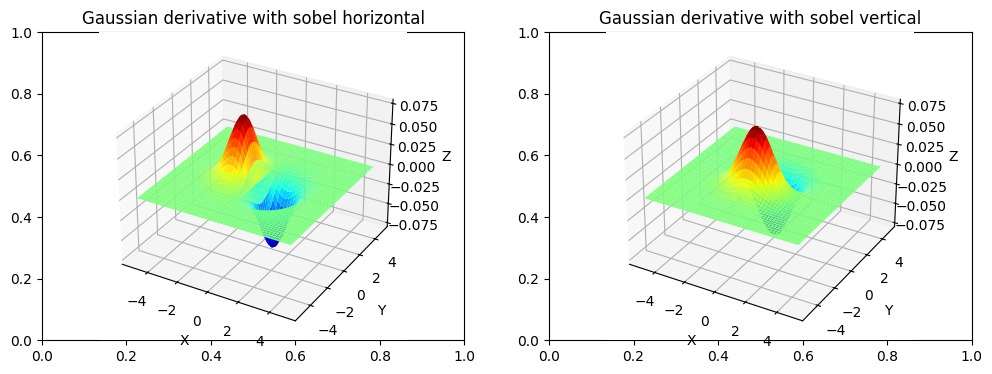

In [2]:
# defining horizontal and vertical sobel kernals
horizontal_sobel_kernal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # enhances vertical lines
vertical_sobel_kernal = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) # enhances horizontal lines

# cross-correlating gaussian with sobel kernals
horizontal_gaussian_derivative = cv.filter2D(Z, -1, horizontal_sobel_kernal)
vertical_gaussian_derivative = cv.filter2D(Z, -1, vertical_sobel_kernal)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1 = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
surf1 = ax1.plot_surface(X, Y, horizontal_gaussian_derivative, cmap='jet', linewidth=0, antialiased= True)
surf2 = ax2.plot_surface(X, Y, vertical_gaussian_derivative, cmap='jet', linewidth=0, antialiased= True)
ax1.set_title("Gaussian derivative with sobel horizontal")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax2.set_title("Gaussian derivative with sobel vertical")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
plt.show()

#### Harris Corners

Let's use the OpenCV's existing function for Harris corners to detect corners in an image

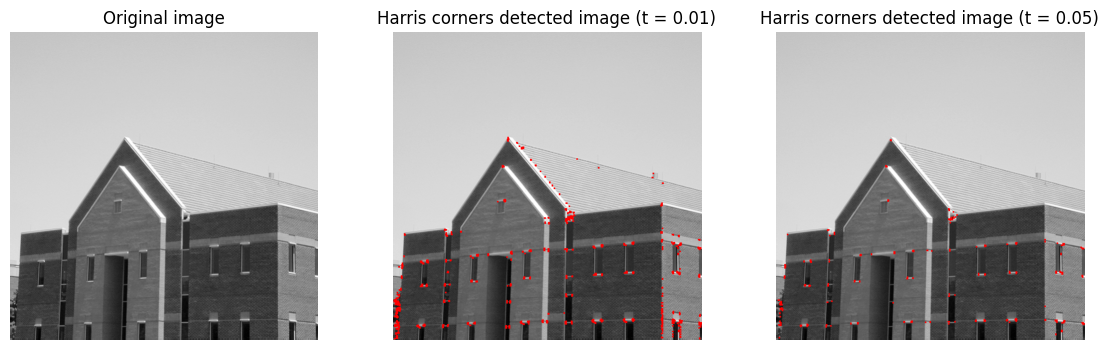

In [3]:
img = cv.imread(r'./Images/building.tif')
img_1 = img.copy()
img_2 = img.copy()
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray)

# using OpenCV's existing function for harris corners
dst = cv.cornerHarris(img_gray, blockSize=2, ksize=3, k=0.04)
dst = cv.dilate(dst, None)

# threshold for an optimal value
img_1[dst > 0.01 * dst.max()] = [0, 0, 255] # t = 0.01
img_2[dst > 0.05 * dst.max()] = [0, 0, 255] # t = 0.05

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(img_1, cv.COLOR_BGR2RGB))
ax[1].set_title("Harris corners detected image (t = 0.01)")
ax[1].axis("off")
ax[2].imshow(cv.cvtColor(img_2, cv.COLOR_BGR2RGB))
ax[2].set_title("Harris corners detected image (t = 0.05)")
ax[2].axis("off")
plt.show()

#### My own implementation for detecting Harris corners

1. **Compute image gradients:**

$$
I_x = \frac{\partial I}{\partial x}, \quad I_y = \frac{\partial I}{\partial y}
$$

2. **Form the structure tensor (second moment matrix):**

$$
M = \begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$

3. **Compute the corner response function \( R \):**

$$
R = \det(M) - k \cdot (\text{trace}(M))^2
$$

$$
\det(M) = \lambda_1 \lambda_2, \quad \text{trace}(M) = \lambda_1 + \lambda_2
$$

4. **Threshold the response \( R \) to classify points:**

$$
R > 0 \Rightarrow \text{Corner}, \quad
R < 0 \Rightarrow \text{Edge}, \quad
R \approx 0 \Rightarrow \text{Flat region}
$$


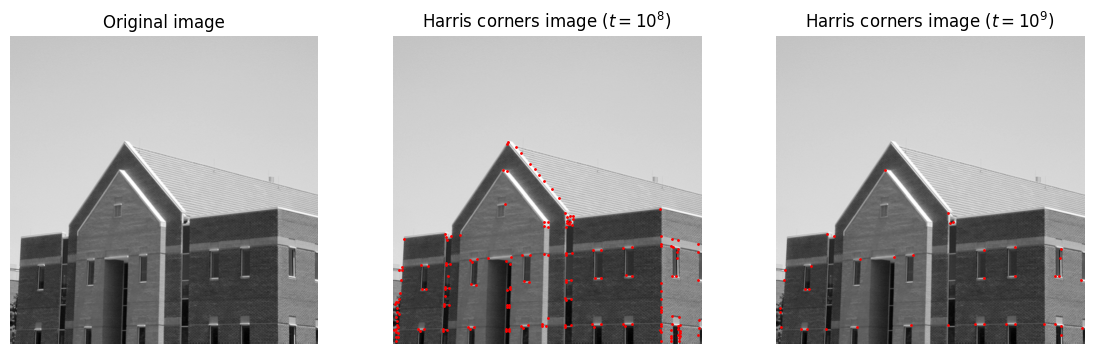

In [4]:
from skimage.feature import peak_local_max

# using sobel kernals to compute image gradients
img_x = cv.filter2D(img_gray, -1, vertical_sobel_kernal)
img_y = cv.filter2D(img_gray, -1, horizontal_sobel_kernal)

# computing elements of the second moment matrix with averaging the gradients
sigma = 1
M11 = cv.GaussianBlur(img_x * img_x, (3, 3), sigma)
M12 = cv.GaussianBlur(img_x * img_y, (3, 3), sigma)
M21 = cv.GaussianBlur(img_x * img_y, (3, 3), sigma)
M22 = cv.GaussianBlur(img_y * img_y, (3, 3), sigma)

# calculating determinant and trace matrices without finding lambda1 and lambda2
det_M = M11 * M22 - M12 * M21
trace_M = M11 + M22

# thresholding
alpha = 0.04
R = det_M - alpha * trace_M**2
R_1 = R.copy()
R_2 = R.copy()

R_1[R_1 < 1e8] = 0 # t = 10^8
coordinates_1 = peak_local_max(R_1, min_distance=2)
R_2[R_2 < 1e9] = 0 # t = 10^9
coordinates_2 = peak_local_max(R_2, min_distance=2)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[1].plot(coordinates_1[:, 1], coordinates_1[:, 0], 'r.', markersize=2)
ax[1].set_title("Harris corners image $(t = 10^8)$")
ax[1].axis("off")
ax[2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[2].plot(coordinates_2[:, 1], coordinates_2[:, 0], 'r.', markersize=2)
ax[2].set_title("Harris corners image $(t = 10^9)$")
ax[2].axis("off")
plt.show()

Analyzing the Harris corner detection function

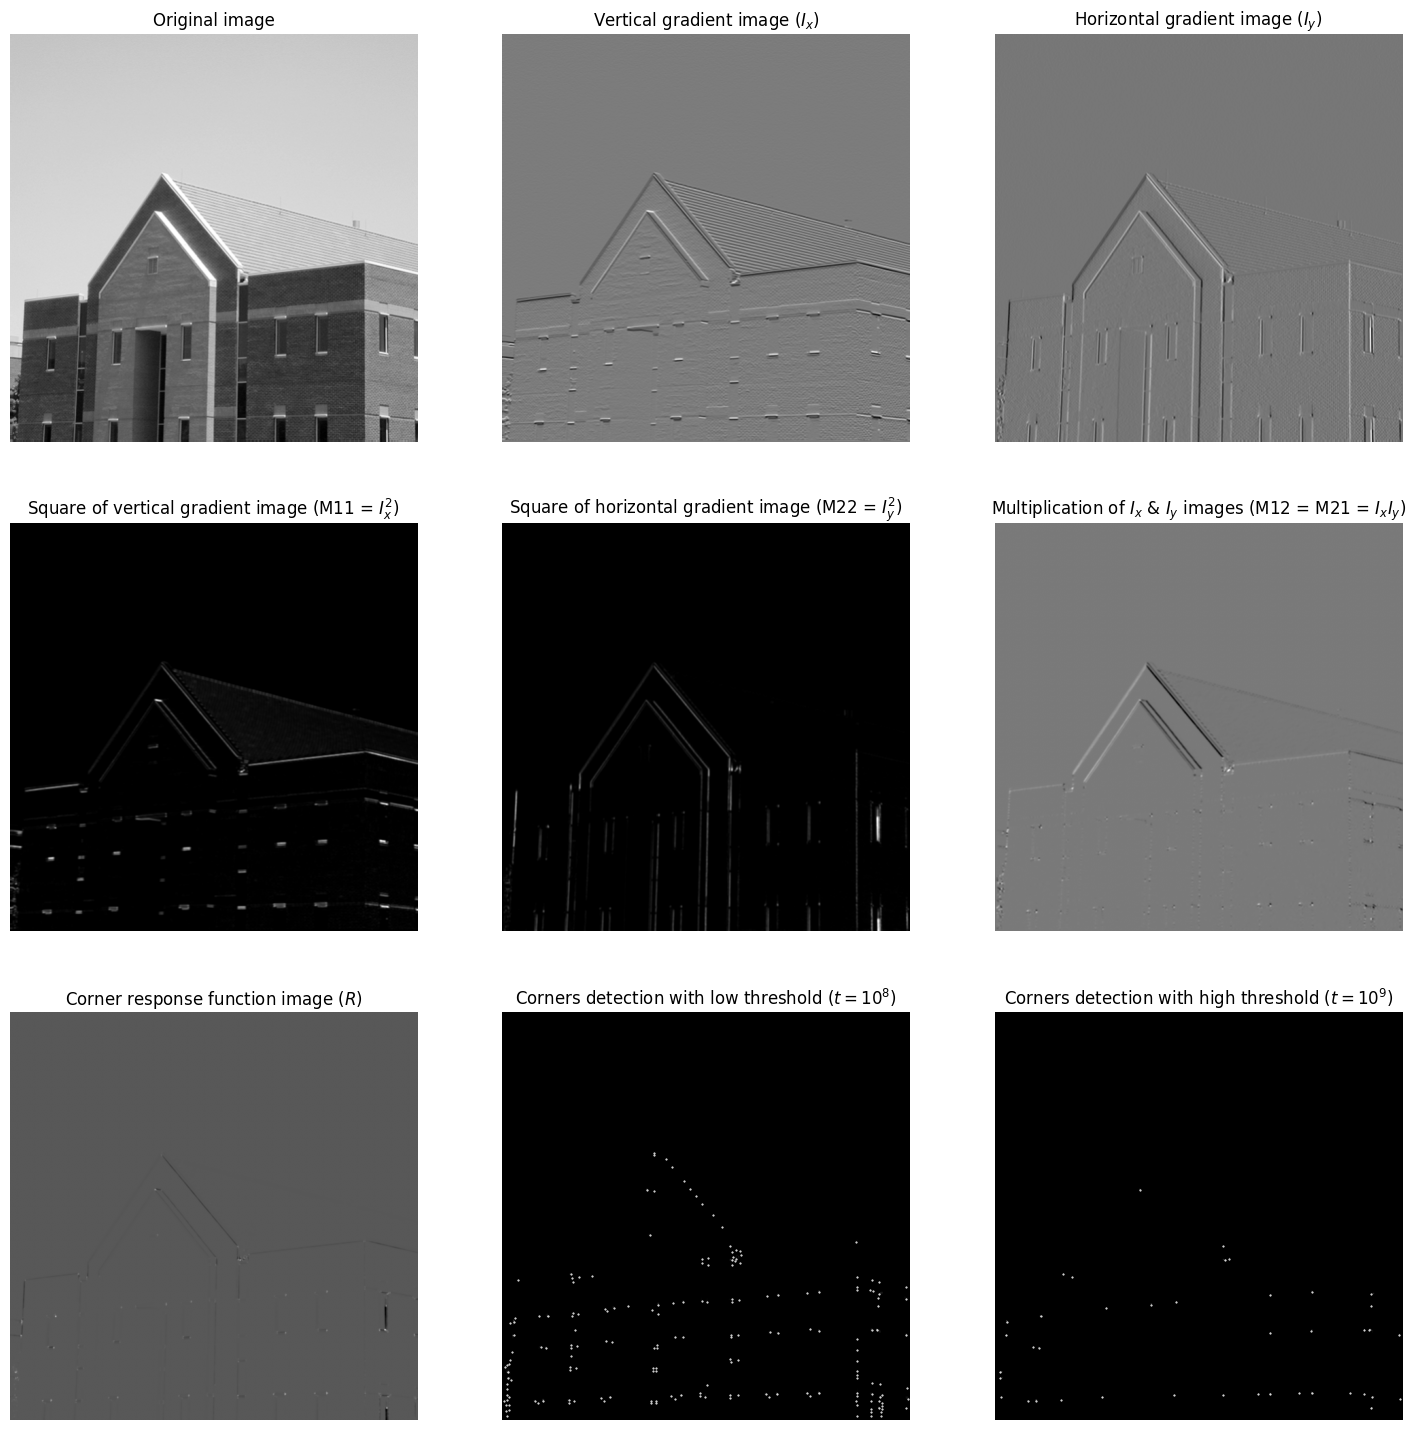

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
ax[0][0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0][0].set_title("Original image")
ax[0][0].axis("off")
ax[0][1].imshow(img_x, cmap="gray")
ax[0][1].set_title("Vertical gradient image ($I_x$)")
ax[0][1].axis("off")
ax[0][2].imshow(img_y, cmap="gray")
ax[0][2].set_title("Horizontal gradient image ($I_y$)")
ax[0][2].axis("off")
ax[1][0].imshow(M11, cmap="gray")
ax[1][0].set_title("Square of vertical gradient image (M11 = $I^2_x$)")
ax[1][0].axis("off")
ax[1][1].imshow(M22, cmap="gray")
ax[1][1].set_title("Square of horizontal gradient image (M22 = $I^2_y$)")
ax[1][1].axis("off")
ax[1][2].imshow(M12, cmap="gray")
ax[1][2].set_title("Multiplication of $I_x$ & $I_y$ images (M12 = M21 = $I_x I_y$)")
ax[1][2].axis("off")
ax[2][0].imshow(R, cmap="gray")
ax[2][0].set_title("Corner response function image ($R$)")
ax[2][0].axis("off")
ax[2][1].imshow(R_1, cmap="gray")
ax[2][1].plot(coordinates_1[:, 1], coordinates_1[:, 0], 'w.', markersize=1)
ax[2][1].set_title("Corners detection with low threshold ($t=10^8$)")
ax[2][1].axis("off")
ax[2][2].imshow(R_2, cmap="gray")
ax[2][2].plot(coordinates_2[:, 1], coordinates_2[:, 0], 'w.', markersize=1)
ax[2][2].set_title("Corners detection with high threshold ($t=10^9$)")
ax[2][2].axis("off")
plt.show()

#### Canny edge detection

Apply Gaussian Blur to reduce image noise.  
Compute gradients using Sobel operators,

$$
G_x = \frac{\partial I_s}{\partial x}, \quad G_y = \frac{\partial I_s}{\partial y}
$$

Then calculate gradient magnitude and direction,

$$
G = \sqrt{G_x^2 + G_y^2}, \quad \theta = \arctan\left( \frac{G_y}{G_x} \right)
$$

Non-Maximum Suppression :-  
threshold2 (T2) : This is the high threshold. Strong edge pixels with gradient magnitude > T2 are immediately considered edges and used to start edge curves.
threshold1 (T1) : This is the low threshold. Weak edge pixels with gradient magnitude between 100 and 200 are included in edges only if they are connected to strong edges. If they’re isolated or not connected in the direction of the gradient, they’re discarded.

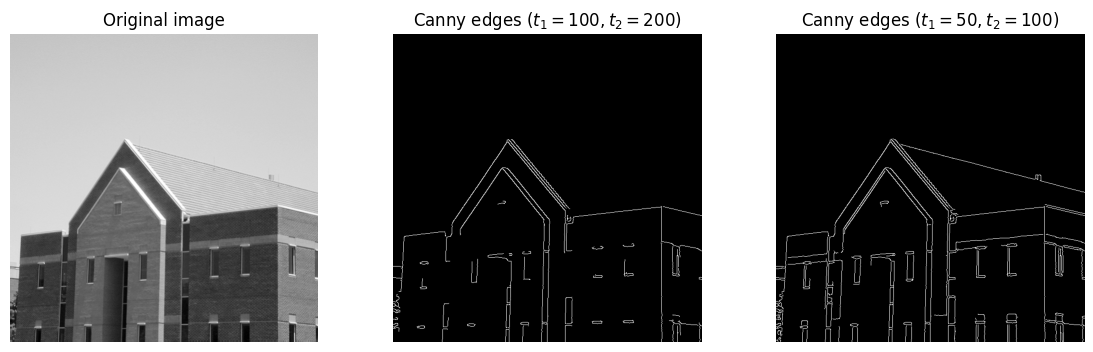

In [6]:
gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# applying gaussian blur to reduce noise
blurred_img = cv.GaussianBlur(gray_image, (5, 5), 1.4)

# using OpenCVs existing Canny edge detection function for detecting edges
edges_img1 = cv.Canny(blurred_img, threshold1=100, threshold2=200)
edges_img2 = cv.Canny(blurred_img, threshold1=50, threshold2=100)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(edges_img1, cmap='gray')
ax[1].set_title('Canny edges ($t_1=100, t_2=200$)')
ax[1].axis('off')
ax[2].imshow(edges_img2, cmap='gray')
ax[2].set_title('Canny edges ($t_1=50, t_2=100$)')
ax[2].axis('off')
plt.show()

#### Matching SIFT features

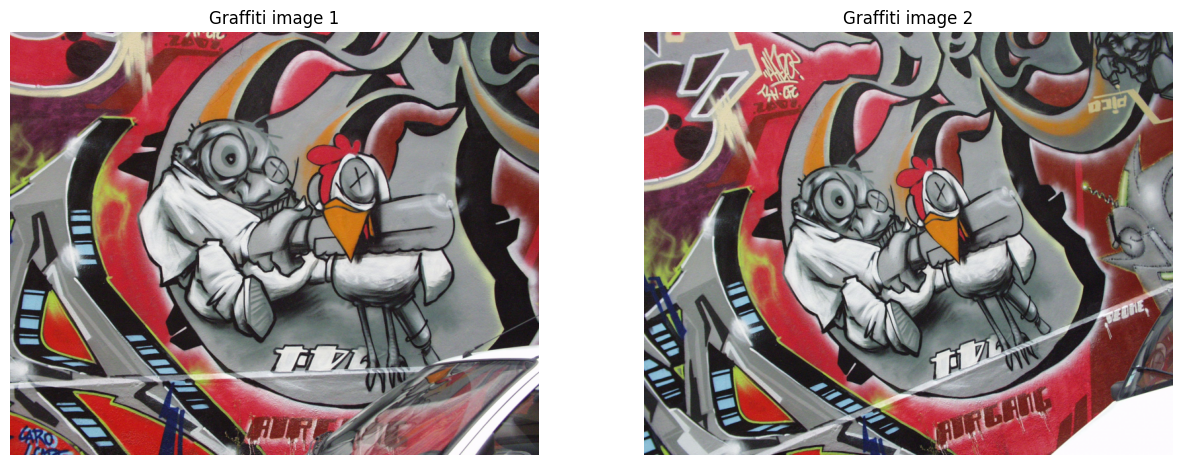

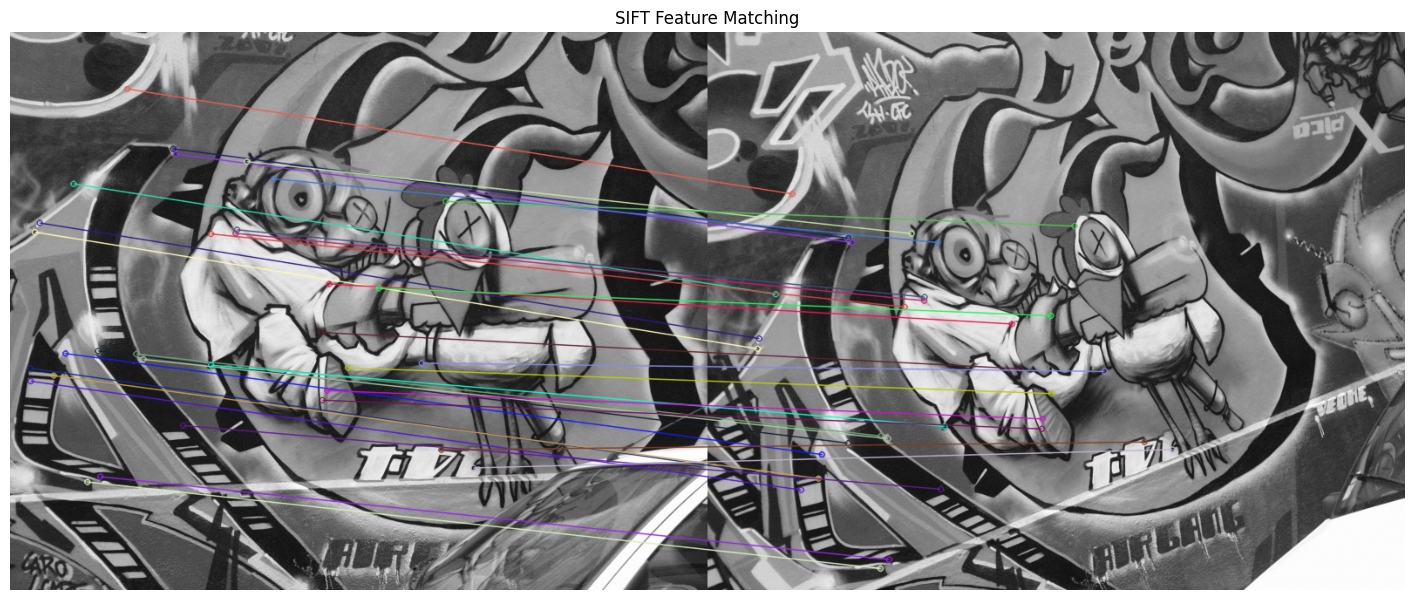

In [7]:
img1_c = cv.imread("Images/graf/img1.ppm", cv.IMREAD_COLOR)
img2_c = cv.imread("Images/graf/img2.ppm", cv.IMREAD_COLOR)
img1 = cv.cvtColor(img1_c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2_c, cv.COLOR_BGR2GRAY)

# initialize SIFT detector
sift = cv.SIFT_create()

# detect and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters and matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.2 * n.distance:
        good_matches.append(m)

# draw matches
img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(cv.cvtColor(img1_c, cv.COLOR_BGR2RGB))
ax[0].set_title("Graffiti image 1")
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img2_c, cv.COLOR_BGR2RGB))
ax[1].set_title("Graffiti image 2")
ax[1].axis('off')

plt.figure(figsize=(18, 8))
plt.imshow(img_matches, cmap="gray")
plt.title("SIFT Feature Matching")
plt.axis('off')
plt.show()
